In [30]:
import sys
print(sys.executable)


d:\Vilnius Gediminas University Work\Second Semester\Image Processing\Counter Task\exercise-counter\.venv\Scripts\python.exe


In [31]:
import mediapipe as mp
print(mp.__version__)


0.10.21


In [32]:
import cv2
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

from pose_detector import PoseDetector
from counter import SquatCounter, PushupCounter, PullupCounter, CrunchCounter
from utils import calculate_angle


In [33]:
from pathlib import Path

BASE_DIR = Path().resolve().parent

mode = input("Select exercise (s = squat, p = pushup, l = pullup, c = crunch): ").strip().lower()

video_map = {
    "s": "squats.mp4",
    "p": "pushup.mp4",
    "l": "pullups.mp4",
    "c": "Crunchs.mp4",   
}

if mode not in video_map:
    raise ValueError("Invalid mode. Use 's' (squat), 'p' (pushup), 'l' (pullup), or 'c' (crunch).")

VIDEO_IN = BASE_DIR / "data" / video_map[mode]
print("Selected video:", VIDEO_IN)

assert VIDEO_IN.exists(), f"Input video not found at: {VIDEO_IN}"


RESULTS_DIR = BASE_DIR / "results"
RESULTS_DIR.mkdir(exist_ok=True)

VIDEO_OUT = RESULTS_DIR / "annotated_video_cn.mp4"
CSV_OUT = RESULTS_DIR / "reps_cn.csv"
PLOT_OUT = RESULTS_DIR / "angle_plot_cn.png"


assert VIDEO_IN.exists(), f"Input video not found at: {VIDEO_IN}"

pose = PoseDetector()



Selected video: D:\Vilnius Gediminas University Work\Second Semester\Image Processing\Counter Task\exercise-counter\data\squats.mp4


In [34]:
from IPython.display import Video

Video(VIDEO_IN, embed=True)


In [35]:
cap = cv2.VideoCapture(str(VIDEO_IN))

width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

writer = cv2.VideoWriter(
    str(VIDEO_OUT),
    cv2.VideoWriter_fourcc(*"mp4v"),
    fps,
    (width, height),
)


In [36]:
#RIGHT_HIP = 24
#RIGHT_KNEE = 26
#RIGHT_ANKLE = 28


In [37]:
frame_idx = 0
records = []

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    results = pose.detect(frame)  

    angle = None

    if results.pose_landmarks:
        lm = results.pose_landmarks.landmark

        p1 = lm[joint_ids[0]]
        p2 = lm[joint_ids[1]]
        p3 = lm[joint_ids[2]]

        pt1 = [p1.x * width, p1.y * height]
        pt2 = [p2.x * width, p2.y * height]
        pt3 = [p3.x * width, p3.y * height]

        angle = calculate_angle(pt1, pt2, pt3)
        counter.update(angle)


        # Draw knee angle
        cv2.putText(
            frame,
            f"Angle: {int(angle)}",
            (int(pt2[0]), int(pt2[1]-15)),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.6,
            (0, 255, 0),
            2,
        )

        # Draw joints
        for p in [p1, p2, p3]:
            cv2.circle(frame, (int(p.x*width), int(p.y*height)), 6, (0,0,255), -1)

    # Squat counter overlay
    cv2.rectangle(frame, (0,0), (260,80), (0,0,0), -1)
    cv2.putText(
        frame,
        f"{exercise_name}: {counter.count}",
        (10,55),
        cv2.FONT_HERSHEY_SIMPLEX,
        1.2,
        (0,255,255),
        3,
    )

    writer.write(frame)

    # Save data
    records.append({"frame": frame_idx, "angle": angle, "count": counter.count})
    frame_idx += 1


In [38]:
cap.release()
writer.release()
pose.close()


In [39]:
df = pd.DataFrame(records)
df.to_csv(CSV_OUT, index=False)
df.head(20)


,frame,angle,count
0,0,167.558718,1
1,1,164.780191,1
2,2,157.812616,1
3,3,151.830003,1
4,4,143.738329,1
5,5,135.568669,1
6,6,126.946261,1
7,7,119.027502,1
8,8,110.489344,1
9,9,102.933167,1


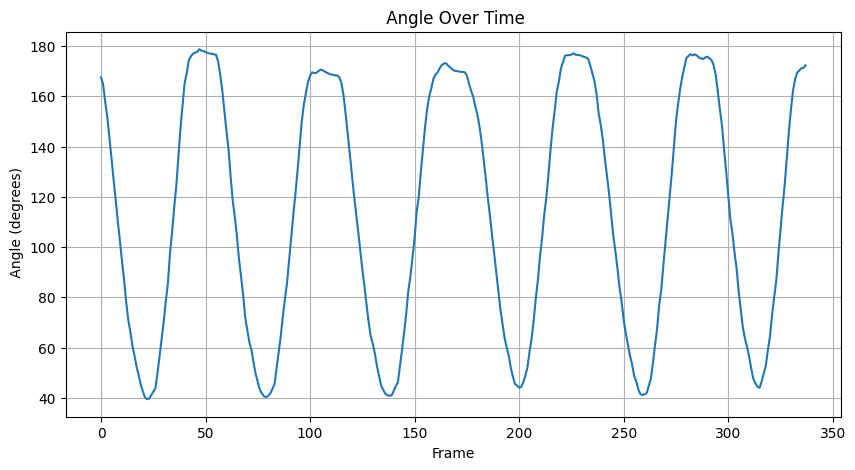

In [40]:
plt.figure(figsize=(10,5))
plt.plot(df["frame"], df["angle"])
plt.xlabel("Frame")
plt.ylabel(" Angle (degrees)")
plt.title(" Angle Over Time")
plt.grid(True)
plt.savefig(PLOT_OUT)
plt.show()


In [41]:
print(f"Total exercise in the video: {counter.count}")


Total exercise in the video: 7


In [42]:
from IPython.display import Video

Video(str(VIDEO_OUT))


In [43]:
import cv2

cap = cv2.VideoCapture(str(VIDEO_OUT))

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    cv2.imshow("Annotated Video", frame)

    # Press 'q' to exit
    if cv2.waitKey(25) & 0xFF == ord("q"):
        break

cap.release()
cv2.destroyAllWindows()
